In [1]:
# !conda env create -f /kaggle/input/condaenv/environment.yml
# !conda init
# !conda activate pestvision
# !wget -P /kaggle/input/ https://storage.googleapis.com/npss-pestvision-data/pestvision_data.zip
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.6/779.6 kB 18.4 MB/s eta 0:00:00


In [2]:
import os
os.environ['WANDB_DISABLED'] = 'true'
import numpy as np
import torch
import yaml
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json

from abc import ABC, abstractmethod
from ultralytics import YOLO
import wandb
from wandb.integration.ultralytics import add_wandb_callback

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from glob import glob
# from natsort import natsorted
from PIL import Image
import torchvision.transforms as T
import xml.etree.ElementTree as ET
from typing import List, Tuple, Optional, Callable, Dict, Any

wandb: WARNING This integration is tested and supported for ultralytics v8.0.238 and below.
wandb: WARNING             Please report any issues to https://github.com/wandb/wandb/issues with the tag `yolov8`.


In [3]:
root = '/kaggle/input/pestvisiondata/pestvision/pestvision_data'
synth_dset_paths = ['synthetic_data/DeepImageBlendingData/run3/RiceLeafs/images/train',
             'synthetic_data/DeepImageBlendingData/run3/paddy-disease-classification/images/train',
             'synthetic_data/Libcom_HarmonizationData_PCTNet/run1/RiceLeafs/images/train',
             'synthetic_data/Libcom_HarmonizationData_PCTNet/run1/paddy-disease-classification/images/train']
synth_dset_paths = [os.path.join(root,i) for i in synth_dset_paths]
val_paths = ["/".join(i.split('/')[:-1]+['val']) for i in synth_dset_paths]
real_paths = ['/kaggle/input/realpestdet/data/images/train']

rval_paths = ['/kaggle/input/pestvision-val/real_dset/images/val']
cust_paths = ['/kaggle/input/realpestdet/data/fuse2/images/train','/kaggle/input/realpestdet/data/fuse4/images/train','/kaggle/input/online-ip102/online_real/images/train','/kaggle/input/online-ip102/ip102/images/train']

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available. Using GPU.")
else:
    device = torch.device('cpu')
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


In [4]:
class AbstractPestDetection(ABC):
    """
    Abstract class for pest detection
    """

    def __init__(self, device):
        self.device = device

    @abstractmethod
    def load_model(self, model_path):
        pass

    @abstractmethod
    def train(self):
        pass

    # TODO: implement evaluate method
    # @abstractmethod
    # def evaluate(self):
    #     pass


class PestDetection_yolov8(AbstractPestDetection):
    """
    YOLOv8 model for pest detection
    """

    def __init__(self, device):
        super().__init__(device)
        self.model = None

    def load_model(self, model_path="yolov8n.pt"):
        """
        Load the YOLOv8 model

        Parameters:

         model_path (str): path to the model checkpoint
        """
        self.model = YOLO(model_path)

    def train(self,**kwargs):

        results = self.model.train(**kwargs)
        self.model.val()

        return results

    # TODO: implment evaluate method
    # def evaluate(self):
    #     pass


In [5]:
def make_dsetconfig(train,val):

    d_config = {
        "train": train,
        "val": val,

        "nc": 102, # number of classes
        "names": [str(i) for i in range(102)] 
    }
    filename = 'data.yaml'
    with open(filename, 'w') as file:
        yaml.dump(d_config, file, default_flow_style=False)
    return filename

In [6]:
def train(checkpoint,train,val,resume = False):
    model = PestDetection_yolov8(device)
    model.load_model(checkpoint)
    results = model.train(data=make_dsetconfig(train,val), epochs=50, imgsz=512, save_period=10,batch=-1, plots=True, resume = resume)

In [7]:
import xml.etree.ElementTree as ET

def convert_to_yolo_format(annotation_file,dest):
    tree = ET.parse(annotation_file)
    root = tree.getroot()
    
    
    size = root.find('size')
    image_width = int(size.find('width').text)
    image_height = int(size.find('height').text)
    
    
    for obj in root.iter('object'):
        name = obj.find('name').text
        bndbox = obj.find('bndbox')
        
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
        
        x_center = (xmin + xmax) / 2.0 / image_width
        y_center = (ymin + ymax) / 2.0 / image_height
        width = (xmax - xmin) / image_width
        height = (ymax - ymin) / image_height
        
        yolo_format = f"{name} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
        
        
        txt_filename = dest
        with open(txt_filename, 'w') as txt_file:
            txt_file.write(yolo_format + '\n')

In [8]:
# annotations_path = '/kaggle/input/pestvisiondata/pestvision/pestvision_data/foreground_data/Detection_IP102/Annotations'
# images_path = '/kaggle/input/pestvisiondata/pestvision/pestvision_data/foreground_data/Detection_IP102/JPEGImages'
# label_path = 'data/labels/train/'
# timage_path = 'data/images/train/'
# if not os.path.isdir(label_path):
#     os.makedirs(label_path)
# if not os.path.isdir(timage_path):
#     os.makedirs(timage_path)

# i = 0
# for filename in os.listdir(annotations_path):
    
#     if filename.endswith('.xml'):
#         xml_file_path = os.path.join(annotations_path,filename)
        
#         convert_to_yolo_format(xml_file_path,os.path.join(label_path,filename.replace('.xml','.txt')))
#         image = Image.open(os.path.join(images_path,filename.replace('.xml','.jpg')))
#         image = image.resize((512,512))
#         image.save(os.path.join(timage_path,filename.replace('.xml','.jpg')))
#         i+=1
# print('#################### completed:',i,'##############################')
        



In [9]:
# train("yolov8n.pt",['/kaggle/input/realpestdet/data/fuse2/images/train','/kaggle/input/realpestdet/data/fuse4/images/train','/kaggle/input/realpestdet/data/fuse8/images/train']+synth_dset_paths, rval_paths, False)

In [10]:
def segment(image):
    
    segment_size = 512
    if min(image.shape[0], image.shape[1])<512:
        segment_size = min(image.shape[0], image.shape[1])
    increment = int(segment_size*(3/4))

    images = []
    pos = []
    
    i = 0
    while i+segment_size<image.shape[0]:
        j = 0
        while j+segment_size<image.shape[1]:
            images.append(image[i:i+segment_size, j:j+segment_size])
            pos.append([i,i+segment_size, j,j+segment_size])
            j+=increment
        i+=increment
    
    i=0
    j=0
    while j+segment_size<image.shape[1]:
        images.append(image[image.shape[0]-segment_size:image.shape[0], j:j+segment_size])
        pos.append([image.shape[0]-segment_size,image.shape[0], j,j+segment_size])
        j+=increment
    while i+segment_size<image.shape[0]:
        images.append(image[i:i+segment_size,image.shape[1]-segment_size:image.shape[1]])
        pos.append([i,i+segment_size,image.shape[1]-segment_size,image.shape[1]])
        i+=increment
    
    images.append(image[image.shape[0]-segment_size:image.shape[0],image.shape[1]-segment_size:image.shape[1]])
    pos.append([image.shape[0]-segment_size,image.shape[0],image.shape[1]-segment_size,image.shape[1]])
    
    return images, pos, segment_size
    
        

def segment_eval(model, image):
    s_images, pos, sz = segment(image) 
    h,w = image.shape[0], image.shape[1]
    
    boxes = torch.empty((0,4),dtype = torch.int)
    confs = torch.empty((0))
    class_ids = torch.empty((0), dtype=torch.int)
    
    for sample_i, sample_pos in zip(s_images, pos):
        results = model.predict(sample_i)[0]
    
        sample_boxes = results.boxes.xyxy.clone()
        sample_boxes[:,0] = sample_boxes[:,0]+sample_pos[2]
        sample_boxes[:,1] = sample_boxes[:,1]+sample_pos[0]
        sample_boxes[:,2] = sample_boxes[:,2]+sample_pos[2]
        sample_boxes[:,3] = sample_boxes[:,3]+sample_pos[0]
        boxes = torch.cat((boxes,sample_boxes),dim=0)
        
        sample_conf = results.boxes.conf
        confs = torch.cat((confs,sample_conf),dim=0)
        
        sample_cids = results.boxes.cls
        class_ids = torch.cat((class_ids, sample_cids),dim=0)
    keep_indices = torch.ops.torchvision.nms(boxes, confs, 0.2)
        
    return boxes.to(torch.int)[keep_indices], confs[keep_indices], class_ids.to(torch.int)[keep_indices]

In [11]:
def plot_image_with_boxes(image, boxes, confidences, class_ids, class_names):
    """
    Plot image with bounding boxes.
    
    Args:
    - image: numpy array representing the image
    - boxes: list of bounding boxes in xyxy format
    - confidences: list of confidence scores
    - class_ids: list of class IDs
    - class_names: list of class names
    """
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for box, confidence, class_id in zip(boxes, confidences, class_ids):
        x1, y1, x2, y2 = box
        box_width = x2 - x1
        box_height = y2 - y1
        
        # Create a rectangle patch
        rect = patches.Rectangle((x1, y1), box_width, box_height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Add class label and confidence score
        class_name = class_names[class_id]
        ax.text(x1, y1, f'{class_name} {confidence:.2f}', color='r', fontsize=8, backgroundcolor='none')

    plt.show()


0: 512x512 (no detections), 245.3ms
Speed: 18.7ms preprocess, 245.3ms inference, 15.7ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 108.2ms
Speed: 2.2ms preprocess, 108.2ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 105.0ms
Speed: 2.3ms preprocess, 105.0ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 99.7ms
Speed: 2.0ms preprocess, 99.7ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 100.5ms
Speed: 2.0ms preprocess, 100.5ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 100.8ms
Speed: 2.1ms preprocess, 100.8ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 99.1ms
Speed: 1.8ms preprocess, 99.1ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 99.4ms
Speed: 1.6ms preproce

<Figure size 640x480 with 0 Axes>

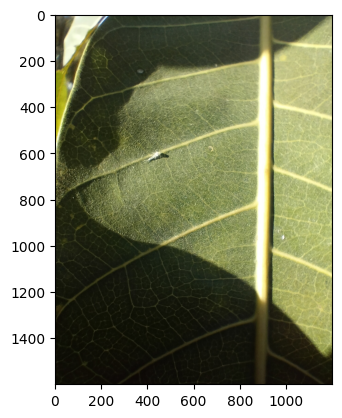

In [12]:
img = imageio.imread('/kaggle/input/pestvision-val/real_dset/images/val/0c1934eb-c792-42fb-b34c-fe21c64b4777.jpg')
model = PestDetection_yolov8(device)
model.load_model('/kaggle/input/yolo/other/exp1/16/last.pt')
boxes, confs, class_ids = segment_eval(model.model, img)
plot_image_with_boxes(img,boxes,confs,class_ids,[str(i) for i in range(1,103)])



In [13]:
# train_path = '/kaggle/input/pest-new-real/Pest Data-3/train2017'
# anno_path = '/kaggle/input/pest-new-real/Pest Data-3/annotations/instances_train2017.json'

# with open(anno_path, 'r') as f:
#     anno = json.load(f)
    
# print(anno['categories'][0].keys())
# print(anno['annotations'][0].keys())
# print(anno['images'][0].keys())
# print([i['id'] for i in anno['images'] if i['file_name']=='061.jpg'])
# print([j['bbox'] for j in anno['annotations'] if j['image_id']==1765])

In [14]:
# image_p = './data1/images/train'
# label_p = './data1/labels/train'

# if not os.path.exists(image_p):
#     os.makedirs(image_p)
# if not os.path.exists(label_p):
#     os.makedirs(label_p)

# # print(len(os.listdir(train_path)))
# cnt = 0
# for i in anno['images']:
#     if os.path.isfile(os.path.join(train_path,i['file_name'])):
#         img = Image.open(os.path.join(train_path,i['file_name']))
#         img.save(os.path.join(image_p,i['file_name']))

#         with open(os.path.join(label_p,i['file_name'].split('.')[0]+'.txt'), 'w') as f:
#             i_anno = [j for j in anno['annotations'] if j['image_id']==i['id']]
#             for j in i_anno:
#                 cate = 0
#                 x = (j['bbox'][0]+j['bbox'][2]/2)/i['width']
#                 y = (j['bbox'][1]+j['bbox'][3]/2)/i['height']
#                 w = j['bbox'][2]/i['width']
#                 h = j['bbox'][3]/i['height']
#                 f.write(' '.join(map(str,[cate,x,y,w,h]))+'\n')
#         cnt+=1
# print('Successful:',cnt)

In [15]:
import os
import random
import cv2
import numpy as np


def resize_and_pad(img, target_size):
    h, w = img.shape[:2]
    scale = min(target_size / h, target_size / w)
    nh, nw = int(h * scale), int(w * scale)
    img_resized = cv2.resize(img, (nw, nh))
    bot_pad = target_size - nh
    right_pad = target_size - nw
    img_padded = cv2.copyMakeBorder(img_resized, 0, bot_pad, 0, right_pad, cv2.BORDER_CONSTANT, value=(0, 0, 0))
    return img_padded, scale, bot_pad, right_pad

def adjust_labels(labels, scale, bot_pad, right_pad, cell_size):
    adjusted_labels = []
    
    for label in labels:
        cls, cx, cy, w, h = label
        cx = (cx*(cell_size-right_pad))/cell_size
        cy = (cy*(cell_size-bot_pad))/cell_size
        w = (w*(cell_size-right_pad))/cell_size
        h = (h*(cell_size-bot_pad))/cell_size
        adjusted_labels.append([cls, cx, cy , w , h])
    return adjusted_labels

def fuse(n, img_paths, label_paths, dest_image, dest_label, n_img):
    if not os.path.exists(dest_image):
        os.makedirs(dest_image)
    if not os.path.exists(dest_label):
        os.makedirs(dest_label)
    target_size = 512
    cell_size = target_size // n
    
    img_files = sorted([os.path.join(p, f) for p in img_paths for f in os.listdir(p) if f.endswith(('.png', '.jpg', '.jpeg'))])
    label_files = sorted([os.path.join(p, f) for p in label_paths for f in os.listdir(p) if f.endswith('.txt')])
    
    
    assert len(img_files) == len(label_files), "Number of image and label files should be the same"
    
#     for i in range(len(img_files)):
    for i in range(n_img):
        img_fused = np.zeros((target_size, target_size, 3), dtype=np.uint8)
        all_labels = []
        
        selected_indices = random.sample(range(len(img_files)), n*n)
        idx = 0
        
        for row in range(n):
            for col in range(n):
                img_path = img_files[selected_indices[idx]]
                label_path = label_files[selected_indices[idx]]
                
                img = cv2.imread(img_path)
                labels = [] #
                with open(label_path, 'r') as f:
                    labels = [list(map(float, line.strip().split())) for line in f.readlines()]
                
                img_resized, scale, top_pad, right_pad = resize_and_pad(img, cell_size)
                
                start_y, start_x = row * cell_size, col * cell_size
                img_fused[start_y:start_y + cell_size, start_x:start_x + cell_size] = img_resized[:cell_size, :cell_size]
                
                adjusted_labels = adjust_labels(labels, scale, top_pad, right_pad, cell_size)
                for label in adjusted_labels:
                    cls, cx, cy, w, h = label
                    cx = (cx * cell_size + start_x) / target_size
                    cy = (cy * cell_size + start_y) / target_size
                    w /= n
                    h /= n
                    all_labels.append([cls, cx, cy, w, h])
                
                idx += 1
        
        img_filename = os.path.join(dest_image, f'fused_{i}.jpg')
        cv2.imwrite(img_filename, img_fused)
        
        label_filename = os.path.join(dest_label, f'fused_{i}.txt')
        with open(label_filename, 'w') as f:
            for label in all_labels:
                f.write(' '.join(map(str, label)) + '\n')

# Example usage:back
# fuse(1, ['/kaggle/input/realpestdet/data1/images/train'], ['/kaggle/input/realpestdet/data1/labels/train'],'online_real/images/train', 'online_real/labels/train',2000)
# fuse(1, ['/kaggle/input/pestvisiondata/pestvision/pestvision_data/background_data/paddy_disease_classification/train/normal','/kaggle/input/pestvisiondata/pestvision/pestvision_data/background_data/paddy_disease_classification/train/dead_heart','/kaggle/input/pestvisiondata/pestvision/pestvision_data/background_data/RiceLeafs/train/blast','/kaggle/input/pestvisiondata/pestvision/pestvision_data/background_data/RiceLeafs/train/normal'], [],'background/images/train', 'background/labels/train',800)
# fuse(1, ['/kaggle/input/realpestdet/data/images/train'], ['/kaggle/input/realpestdet/data/labels/train'],'ip102/images/train', 'ip102/labels/train',4000)
fuse(2, ['/kaggle/input/background/background/images/train','/kaggle/input/realpestdet/data/images/train'], ['/kaggle/input/background/background/labels/train','/kaggle/input/realpestdet/data/labels/train'],'data/fuse2/images/train', 'data/fuse2/labels/train',13000)
fuse(4, ['/kaggle/input/background/background/images/train','/kaggle/input/realpestdet/data/images/train'], ['/kaggle/input/background/background/labels/train','/kaggle/input/realpestdet/data/labels/train'],'data/fuse4/images/train', 'data/fuse4/labels/train',13000)
fuse(8, ['/kaggle/input/background/background/images/train','/kaggle/input/realpestdet/data/images/train'], ['/kaggle/input/background/background/labels/train','/kaggle/input/realpestdet/data/labels/train'],'data/fuse8/images/train', 'data/fuse8/labels/train',13000)

In [16]:
# with open('data/labels/train/fused_72.txt','r') as f:
#     data = f.readlines()
# print(data)


In [17]:
def plot_using_box(img_path, label_path):
    img = np.array(Image.open(img_path), dtype = np.uint8)
    with open(label_path,'r') as f:
        lines = f.readlines()
    labels = [[float(j) for j in i.split()] for i in lines]
    adjusted_labels = []
    H,W,C = img.shape
    for i in labels:
        x,y,w,h = i[1], i[2], i[3], i[4]
        x1 = int((x-w/2)*W)
        x2 = int((x+w/2)*W)        
        y1 = int((y-h/2)*H)        
        y2 = int((y+h/2)*H)
        adjusted_labels.append([x1,y1,x2,y2])
    plot_image_with_boxes(img, adjusted_labels, [1 for i in range(len(labels))], [0 for i in range(len(labels))], ['1' for i in range(len(labels))])
    
# plot_using_box('/kaggle/working/data/fuse4/images/train/fused_30.jpg','/kaggle/working/data/fuse4/labels/train/fused_30.txt')
    